# Autoencoder with MNIST CNN

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Flatten, Reshape, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

BATCH_SIZE = 128
IMG_SIZE = 28
NUM_CLASSES = 10
NUM_EPOCHS = 10

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    y = np.array(ydata)
    X = np.array(xdata).reshape((-1, IMG_SIZE, IMG_SIZE, 1))
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


## Define Network

In [4]:
xin = Input(batch_shape=(None, IMG_SIZE, IMG_SIZE, 1))
# encoder
conv1 = Conv2D(1, kernel_size=(2, 2), padding="same", 
               activation="relu")(xin)
pool1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)
conv2 = Conv2D(64, kernel_size=(2, 2), padding="same",
               activation="relu")(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv2)
# hidden
hidden = GlobalAveragePooling2D()(pool2)
hidden_r = Reshape((8, 8, 1))(hidden)
# decoder
deconv2 = Conv2DTranspose(64, kernel_size=(2, 2), padding="same",
                         activation="relu")(hidden_r)
upsamp2 = UpSampling2D(size=(2, 2))(deconv2)
deconv1 = Conv2DTranspose(1, kernel_size=(2, 2), padding="same",
                         activation="relu")(upsamp2)
upsamp1 = UpSampling2D(size=(2, 2))(deconv1)
xout = Lambda(lambda x: tf.image.resize_image_with_crop_or_pad(
    x, IMG_SIZE, IMG_SIZE))(upsamp1)

autoencoder = Model(inputs=xin, outputs=xout)

In [5]:
for layer in autoencoder.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

input_1 (None, 28, 28, 1) (None, 28, 28, 1)
conv2d_1 (None, 28, 28, 1) (None, 28, 28, 1)
max_pooling2d_1 (None, 28, 28, 1) (None, 14, 14, 1)
conv2d_2 (None, 14, 14, 1) (None, 14, 14, 64)
max_pooling2d_2 (None, 14, 14, 64) (None, 7, 7, 64)
global_average_pooling2d_1 (None, 7, 7, 64) (None, 64)
reshape_1 (None, 64) (None, 8, 8, 1)
conv2d_transpose_1 (None, 8, 8, 1) (None, 8, 8, 64)
up_sampling2d_1 (None, 8, 8, 64) (None, 16, 16, 64)
conv2d_transpose_2 (None, 16, 16, 64) (None, 16, 16, 1)
up_sampling2d_2 (None, 16, 16, 1) (None, 32, 32, 1)
lambda_1 (None, 32, 32, 1) (None, 28, 28, 1)


In [6]:
autoencoder.compile(optimizer="adam", loss="mse")

## Train Network

In [7]:
history = autoencoder.fit(Xtrain, Xtrain, batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS, 
                          validation_data=(Xtest, Xtest))

/Users/palsujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.4-py2.7.egg/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s - loss: 0.0675 - val_loss: 0.0639

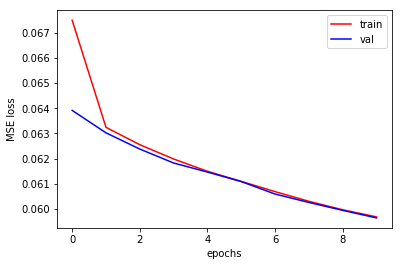

In [8]:
plt.plot(np.arange(NUM_EPOCHS), history.history["loss"], 
         color="r", label="train")
plt.plot(np.arange(NUM_EPOCHS), history.history["val_loss"], 
         color="b", label="val")
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.legend(loc="best")

## Visualize Autoencoder outputs

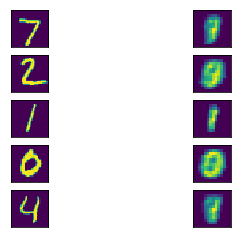

In [9]:
Xviz = Xtest[0:5]
Xviz_ = autoencoder.predict(Xviz)
j = 1
for i in range(5):
    img_orig = Xviz[i].reshape(28, 28)
    img_ae = Xviz_[i].reshape(28, 28)
    plt.subplot(5, 2, j)
    plt.imshow(img_orig)
    plt.xticks([])
    plt.yticks([])
    j += 1
    plt.subplot(5, 2, j)
    plt.imshow(img_ae)
    plt.xticks([])
    plt.yticks([])
    j += 1
plt.show()

## Visualize Encoder embeddings

In [10]:
encoder = Model(inputs=xin, outputs=hidden)
xout_ = encoder.predict(Xtest)
print(Xtest.shape, xout_.shape)

(10000, 28, 28, 1) (10000, 64)


In [11]:
tsne = TSNE(n_components=2)
Z = tsne.fit_transform(xout_)
print(Z.shape)

(10000, 2)


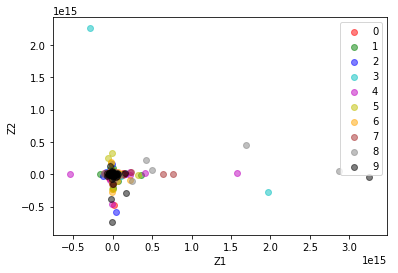

In [12]:
colors = ["r", "g", "b", "c", "m", "y", "orange", "brown", "gray", "k"]
for i in range(NUM_CLASSES):
    yi_indices = np.where(ytest == i)[0]
    xi = Z[yi_indices][:, 0].tolist()
    yi = Z[yi_indices][:, 1].tolist()
    plt.scatter(xi, yi, color=colors[i], alpha=0.5, label=str(i))
plt.legend(loc="best")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.show()